In [157]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

a link to a csv file: 'https://drive.google.com/file/d/1wTHa4Ajhj6VJy5cOWPO9fFz49-krRQq_/view?usp=drive_link'
name of the file: 'SouvenirSales.csv'

In [178]:
#Create a .csv file out of the given data and put it online (you will use a link to it in your program).
data = pd.read_csv('SouvenirSales.csv')
data

,Date,Sales
0,Jan.95,1664.81
1,Feb.95,2397.53
2,Mar.95,2840.71
3,Apr.95,3547.29
4,May.95,3752.96
...,...,...
79,Aug.01,28586.52
80,Sep.01,30505.41
81,Oct.01,30821.33
82,Nov.01,46634.38


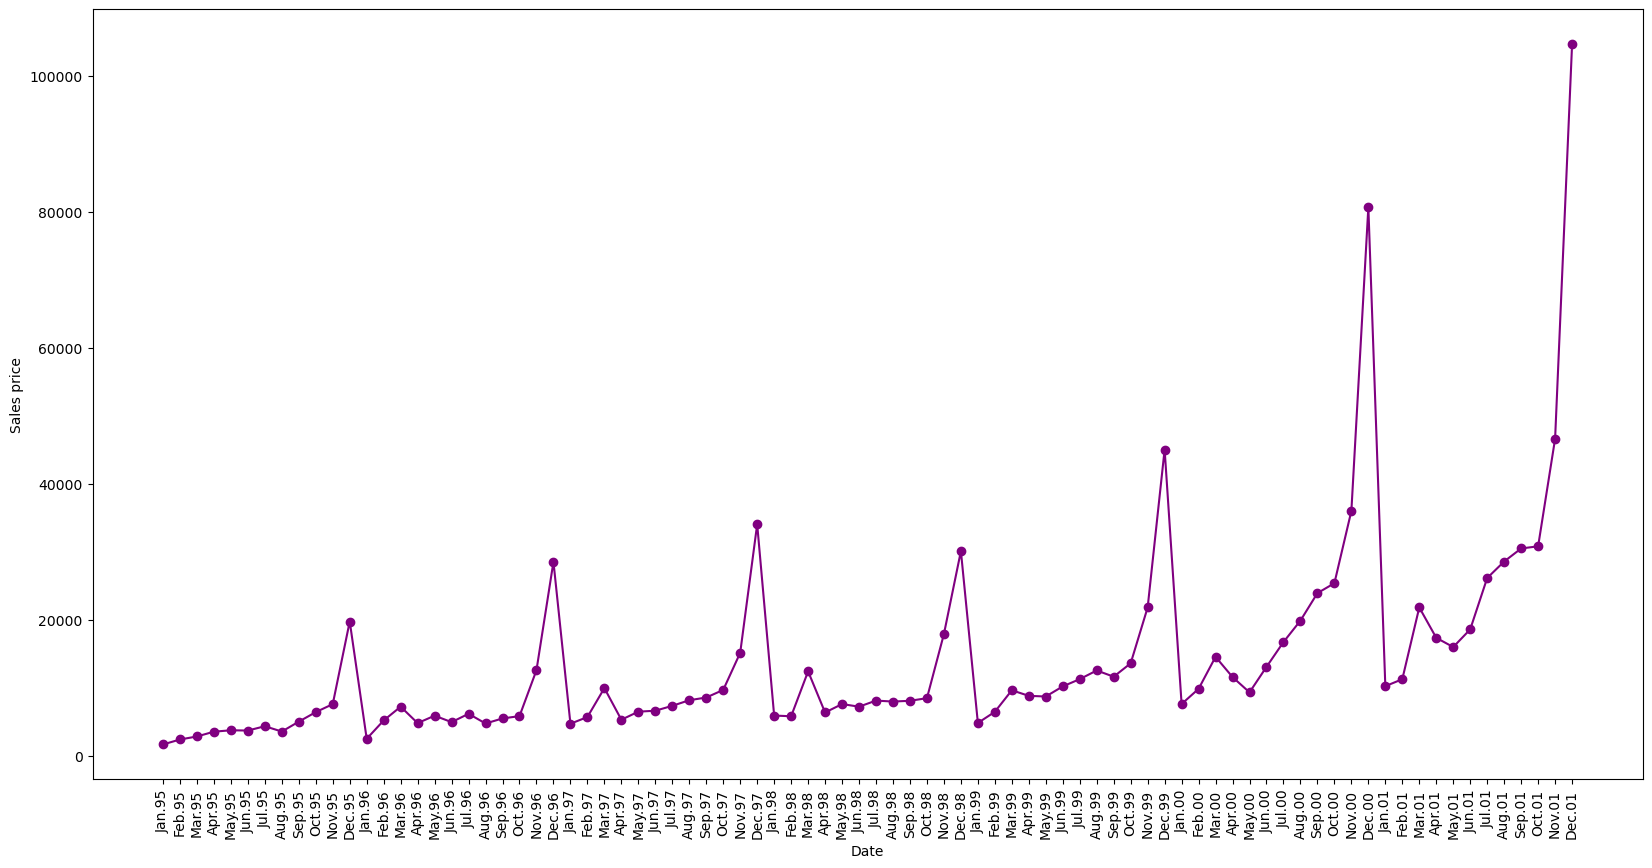

In [179]:
#Plot data
fig = plt.figure(figsize=(20, 10))
plt.scatter(data['Date'], data['Sales'], color = 'purple')
plt.plot(data['Date'], data['Sales'], '-', color = 'purple')
plt.xlabel('Date')
plt.ylabel('Sales price')

# Set the tick locations and labels on the x-axis
plt.xticks(rotation = 90)
plt.show()

In [180]:
#Run the ADF test and check if the process is stationary. If not, apply differencing.
ADF_result = adfuller(data['Sales'])
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: 2.3165441049030133
p-value: 0.9989654538596133


As we can see, the p-value is bigger than 0.05, which means that the process is not stationary and we have to apply differencing

In [181]:
#differencing
sales_diff = np.diff(data['Sales'], n=1)

In [182]:
#running the adf again to check the stationary now
ADF_result = adfuller(sales_diff)
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -2.16548009236609
p-value: 0.21901181581867774


As we can see, p-value is still not smaller than the 0.05 which means that the process is still not stationary after applying differencing. That's why we will aplly it one more time(or we could've changed the oreder of the first differencing to the second)

In [183]:
sales_diff_1 = np.diff(sales_diff, n=1)
len(sales_diff_1)

82

In [184]:
ADF_result = adfuller(sales_diff_1)
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -8.661375066146602
p-value: 4.812257360865132e-14


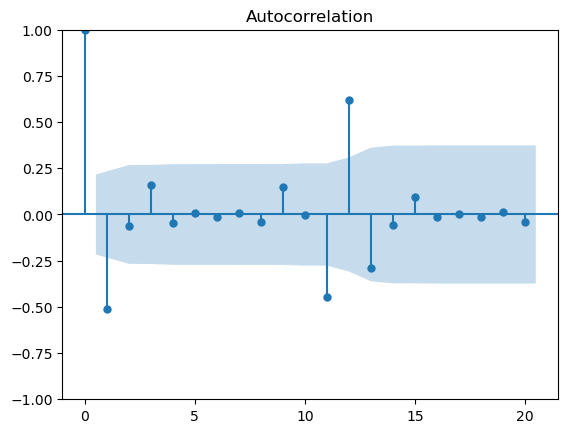

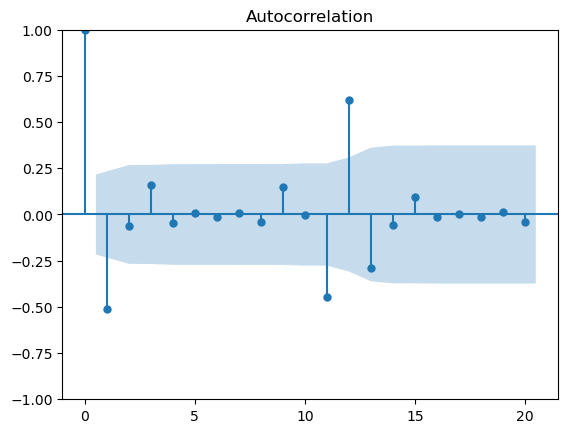

In [185]:
#Plot the ACF. What can you see?
plot_acf(sales_diff_1, lags=20)

We can see that there is no lag at which the coefficients abruptly become non-significant. So, it
is not a moving average process

C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


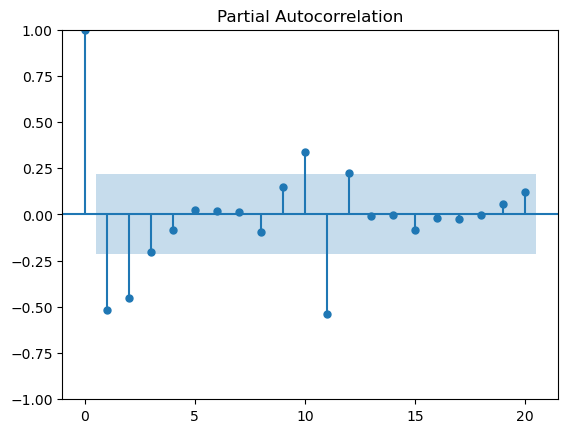

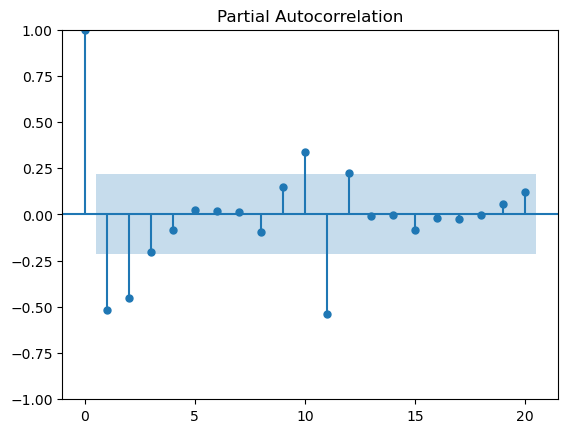

In [186]:
#Plot the PACF. After what lag the coefficients become abruptly nonsignificant?
plot_pacf(sales_diff_1, lags = 20)

As we can see from the plot it is not possible to figure out after what lag the coefficients become abruptly nonsignificant. The reason for it may be fact that the amount of data is not enough for the plots to be 'correct' 

In [187]:
df_diff = pd.DataFrame({'sales_diff': sales_diff_1})

In [188]:
#Separate your series into a train set and a test set.
train = df_diff[:-12]
test = df_diff[-12:]

In [189]:
#Make forecasts over the test set. Use the historical mean method, last known value
#method, and an AR(p) model for an appropriate p. Apply a window of length 2.
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    total_len = train_len + horizon
    if method == 'mean':
        pred_mean = [] 
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
        return pred_mean
    elif method == 'last':
        pred_last_value = []
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
        return pred_last_value
    elif method == 'AR':
        pred_AR = []
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(4,0,0))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            pred = predictions.predicted_mean.iloc[-window:]
            pred_AR.extend(pred)
        return pred_AR

In [190]:
pred_df = test.copy()
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2 # we wish to predict the next timestep
pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW,'last')
pred_AR = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'AR')
pred_df['pred_mean'] = pred_mean
pred_df['pred_last_value'] = pred_last_value
pred_df['pred_AR'] = pred_AR

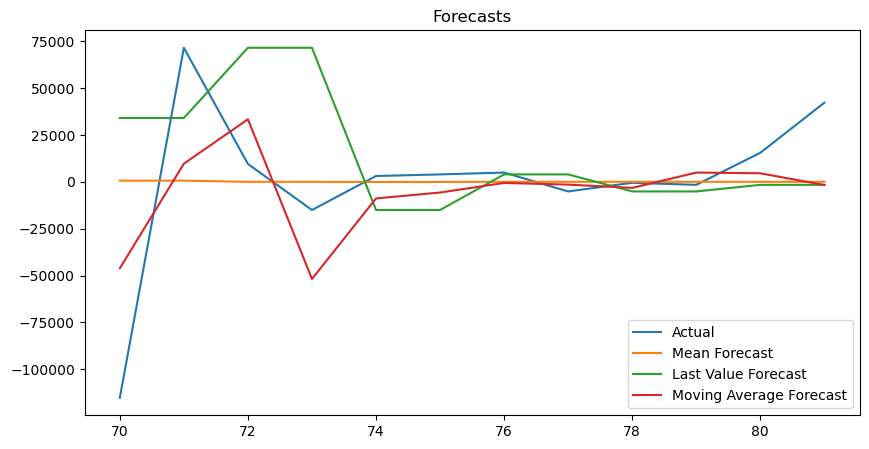

In [191]:
#Plot your forecasts.
plt.figure(figsize=(10, 5))
plt.plot(pred_df.index, test, label='Actual')
plt.plot(pred_df.index, pred_mean, label='Mean Forecast')
plt.plot(pred_df.index, pred_last_value, label='Last Value Forecast')
plt.plot(pred_df.index, pred_AR, label='Moving Average Forecast')
plt.title('Forecasts')
plt.legend()
plt.show()

In [192]:
#Measure the MSE. Which method is the best?
mse_mean = mean_squared_error(pred_df['sales_diff'], pred_mean)
mse_last = mean_squared_error(pred_df['sales_diff'], pred_last_value)
mse_AR = mean_squared_error(pred_df['sales_diff'], pred_AR) 

print("Historical mean error: ", mse_mean) 
print("Last known value error: ", mse_last) 
print("AR(3) error: ", mse_AR) 

Historical mean error:  1737768219.9356382
Last known value error:  3168379419.660375
AR(3) error:  1074549937.3924932


In [214]:
#Reverse differencing if needed, plot the best forecast and calculate the MAE
data['pred_sales'] = pd.Series()
data['pred_sales'][72:] = sales_diff[-72] + pred_df['pred_AR'].cumsum()

data['pred_sales_1'] = pd.Series()
data['pred_sales_1'][72:] = data['Sales'].iloc[72] + data['pred_sales'].iloc[72]

C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\ipykernel_launcher.py:6: SettingWit

In [215]:
mae_AR_undiff = mean_absolute_error(data['Sales'][72:], data['pred_sales_1'][72:])
print("MAE of the best: ", mae_AR_undiff) 

MAE of the best:  83338.62799287845


In [216]:
#Now, compute a forecast for January 2002
pred_january = rolling_forecast(df_diff, len(df_diff), 1, 1, 'AR')

In [217]:
result = pred_january + sales_diff[-1] + data.iloc[-2]['Sales']

In [218]:
result

array([40984.12971337])